<a href="https://colab.research.google.com/github/ray4wit/Financial_Date_Science/blob/main/Fama_French_1993_pub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fama & French (1993) Replication

### Background
A vital implication of the Capital Asset Pricing Model (CAPM) is that market beta is sufficient to explain the cross-section of expected stock returns. Specifically, the expected returns of individual stock should not be associated with corporate characteristics. Researchers and practitioners have identified many firm characteristics, known as anomalies, that correlate with the cross-section return of stocks over the years. Fama and French (1992, 1993, and 1996) suggested that these anomalies exist because CAPM is inadequate (rather than market inefficiency). Based on early findings, they contend that the CAPM fails to account for risk factors, such as SIZE and VALUE, and suggest an empirical approach for overcoming the systematic mispricing of the CAPM model.  
  
In particular, they integrate two more factors, HML and SML into the CAPM model:  
<div style="display: flex; gap:10px;">
  <img src="http://drive.google.com/uc?export=download&id=12Kwd8olDPwOqMJedRdswtV59pc0yOOVZ" alt="img"/>
  <p style="font-size: 30px;">
    Does this work?
  </p>
</div>

![FFM Formula](http://drive.google.com/uc?export=download&id=12Kwd8olDPwOqMJedRdswtV59pc0yOOVZ)

- SMB(Small Minus Big) represents the difference between the returns to portfolios of small- and large-capitalization firms 
    - A portfolio return from buying stocks of small firms while selling stocks of large firms  
- HML(High Minus Low) represents the difference between the returns to portfolios of high and low B/M (Book Value/Market capitalization) ratio firms
    - A portfolio return from buying stocks of value firms while selling stocks of growth firms 
- Thus, the regression coefficients of those two mimicking portfolio factors represent exposures to size and value risk in the same way that beta measures the exposure to market risk.  
![FFM Formula](http://drive.google.com/uc?export=download&id=12QyHDHY4AB5Y8QYVkY1CF8dMNWebseU9)

### Tasks and Requirements
This online course will present an academic replication of Fama and French (1993)'s factor construction in Python and SQL. The following package and data subscriptions are required to excute the program:
- Python packages: pandas, sqlite3, datetime, and wrds
- WRDS data subscriptions: CRSP, Compustat, and CRSP/Compustat Merged   

#### Stock Price Data (CRSP)
The Center for Research in Security Prices (CRSP) maintains the most comprehensive collection of stockes listed in major the US stock exchanges and has long been considered as the data source of stock prices in US by academic researchers in financial economic and accounting fields. Fama and French (1993) imposes a set of selection filters over CRSP universe: 
- A firm must have stocks prices for Dec at year t-1, and Jun at year t
- A stock must have a share code of 10 or 11 (Exclude ADRs, ETFs, etc.) and primarily listed in NYSE, AMEX, and Nasdaq 
> - NYSE at 1925, NYSE MKT(AMEX) in 1962, Nasdaq in 1972, ARCA in 2006, and Bats in 2012  
>   - Stocks listed in NYSE MKT and Nasdaq also tended to be smaller than NYSE stocks   
> - NYSE breakpoints are always used to ensure consistence and representativeness  
>   - “The median NYSE size is then used to split NYSE, Amex and NASDAQ stocks into two groups, small and big (S and B).”   

#### Fundamental Data (Compustat) 
Compustat contains fundamental financial for active and inactive publicly traded US firms back to 1950. It is the sources researchers coventionally used to obtain accounting data items in academic researches. 
- A firm must have positive book common equity for year t-1 (Fiscal)
> - book common equity is measured as 
>   - stockholders’ equity + balance-sheet deferred taxes - book value of preferred stock
>     - depending on availability, the redemption, liquidation, or par value (in that order) is used to estimate the value of preferred stock
> - A firm must have appeared in Compustat for two years
>   - Survival bias: In early years, Compustat only includes firms with more than two years of historical data when it adds firms (i.e., companies that did not make its third year are excluded) 

#### Emprical Notes
- CRSP and Compustat universe are different, but neither is a superset of the other
> - Portfolio Construction is at each Jun, i.e., the portfolio is rebalanced or reconstructed at the last trading date of each June (after trading hours)
>   - SMB is based on the Market Capitalization at each June end
>   - HML is, however, based on Book value of equity at the end of Fiscal year t-1 (previous Jun to current May), and
Market value of equity at the end (December) of calendar year t-1!
![FFM Formula](http://drive.google.com/uc?export=download&id=125wcrwP961BBjGilXroPTiK5SkKkxm77)


In [ ]:
#Install wrds(Wharton Research Data Services) package for data access
!pip install wrds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from datetime import datetime 
from pandas.tseries.offsets import MonthEnd

import sqlite3, wrds

In [ ]:
wrds_sql = wrds.Connection()

Enter your WRDS username [root]:rdai
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


> I generally utilize sqlite3 for data merging over a date range to avoid equivalent but slightly cumbersome code in pandas. In addition, when data size is considerably large relatively to the memory available, sqlite3 allows to use disk as well: `conn = sqlite3.connect('ff_demo.db')`

In [ ]:
local_sql = sqlite3.connect(':memory:')  

> Compustat Data Retrieval and Cleansing:
> - *GVKEY:* a unique identifier and primary key for each company in the Compustat (Global Company Key,)
> - *DATADATE:* reporting date for a data record in Compustat, such as fiscal year end.   
> - *FYEAR:* fiscal year of the current fiscal year-end month. If the current fiscal year-end month falls in January through May, this item is the current calendar year minus 1 year.
> - *INDFMT:* whether a company reports in a Financial Services or Industrial format. By default, INDL is preferred, but FS is only available for certain firms.  
> - *DATAFMT:*   how the data is collected and presented. It is default to select STD(Standardized) for Compustat NA data.   
> - *POPSRC:* source of the data, POPSRC =D for Domestic (USA, Canada and ADRs), Otherwise POPSRC =I
> - *CONSOL:* whether a company's financial statements represent consolidated  (CONSOL = C) or nonconsolidated information.   

![FFM Formula](http://drive.google.com/uc?export=view&id=11hvqJlxlhnirGE7c9g5XDRHbvLiQ5upN)

In [ ]:
comp = wrds_sql.raw_sql("""
          select distinct gvkey, indfmt, datafmt, popsrc, consol, fyear, 
          datadate, PSTKRV, PSTKL, PSTK, sale, at, lt, seq, TXDITC
          from comp.funda
          order by gvkey, fyear, datadate
        """)

In [ ]:
comp=comp[(comp['indfmt']=='INDL') & (comp['datafmt']=='STD') & (comp['popsrc']=='D') & (comp['consol']=='C')]

In [ ]:
comp.set_index('gvkey', inplace=True)
comp['datadate']=pd.to_datetime(comp['datadate'])
# comp.info()

In [ ]:
# comp.loc['001690']

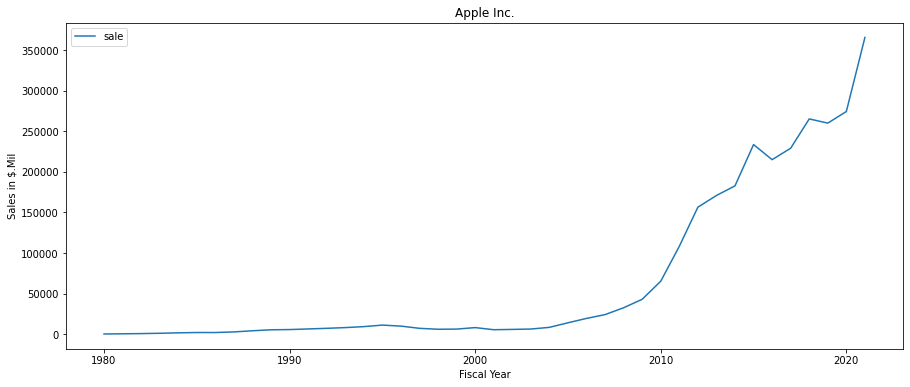

In [ ]:
comp.loc['001690'].plot.line('fyear','sale', title='Apple Inc.', ylabel='Sales in $.Mil', xlabel='Fiscal Year', figsize=(15,6))

> Fama and French (1993): 
> - “We define book common equity, BE as the COMPUSTAT book value of stockholders equity, plus balance-sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock.” 
> - “Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the value of preferred stock.”

> Preferred Shares Related Variables:
> - *PSTKR*: total dollar value of the net number of preferred shares outstanding multiplied by the voluntary liquidation or redemption value per share whichever is greater. 
> - *PSTKL*: total dollar value of the net number of preferred shares outstanding in the event of involuntary liquidation (such as, bankruptcy) multiplied by the per share involuntary liquidating value.
> - *PSTK*: preferred shares at year-end multiplied by the par or stated value per share as presented in the company's Balance Sheet.

In [ ]:
comp['PreShareValue']=comp[['pstkrv', 'pstkl', 'pstk']].bfill(axis=1).iloc[:, 0].fillna(0) #  use the redemption, liquidation, or par value (in that order)

> More Compustat Variables:
> - SEQ:  common and preferred shareholders' interest in the company
> - TXDITC: accumulated tax deferrals due to timing differences between the reporting of revenues and expenses for financial statements and tax forms and investment tax credit

In [ ]:
comp['be']=comp['seq']+comp['txditc'].fillna(0)-comp['PreShareValue']

> Fama and French (1993):
> - “To avoid the survival bias inherent in the way COMPUSTAT adds firms to its tapes, we do not include firms until they have appeared on COMPUSTAT for two years.”
>   - Adding this condition would slightly reduce the correlation coefficient between this replication and data from Prof. French's data library, which may imply that the official “Fama French” factors may no longer take consideration of the survivorship bias documented in early papers. 
>   - In fact, Compustat now updates (and corrects) its data on daily basis, so that this previously documented bias may no longer exist in recent Compustat data.  

In [ ]:
comp['age']=comp['fyear']-comp.groupby('gvkey').first()['fyear']

In [ ]:
comp=comp[['fyear','datadate', 'be', 'age']]

>Compustat Data Retrieval and Cleansing:
> - *PERMNO:* a primary and permnent security identifier within CRSP database, and one company may have several stocks at one time.
> - *PERMCO:* a unique permanent company identifier within CRSP database. 
> - *SHRCD:* a two-digit code describing the type of shares traded. SHRCD=10 or 11 are usually used for US Common Stocks
> - *EXCHCD:* a code indicating the exchange on which a security is listed. Normal exchange codes are respectively 1,2, and 3 for NYSE, AMEX and the Nasdaq. 
> - *PRC:* the closing price or **the negative bid/ask average in the last trading day of a month**.
> - *SHROUT:* the number of publicly held shares, recorded in thousands
> - *RET:* the change in the total value of an investment in a common stock over some period of time per dollar of initial investment
> - *CFACPR:* A factor which takes into account splits so you could calculate a split-adjusted price, but it does not include dividends.
> - *DLRET:* Return of the security after it is delisted. It is calculated by comparing a value after delisting against the price on the security's last trading date. 

In [ ]:
msf = wrds_sql.raw_sql("""
          select distinct a.permno, a.permco, a.date, ncusip, ticker, comnam, prc, shrout, ret, retx, 
          dlret, (1 + coalesce(ret,0))*(1 + coalesce(dlret,0)) -1 as retadj, vol, vwretd, ewretd, sprtrn, cfacpr, cfacshr, shrcd, exchcd
          from crsp.msf as a inner join crsp.msenames as b
          on a.permno=b.permno and date>=NAMEDT and date<=NAMEENDT 
          and SHRCD in (10, 11, 12, 31) and EXCHCD in (1, 2, 3)
          inner join crsp.msi as c
          on a.date=c.date
          left join crsp.msedelist as d
          on a.permno=d.permno and a.date=d.DLSTDT
          order by a.permco, a.permno, a.date
        """)

In [ ]:
msf.set_index('permno', inplace=True)
msf['date']=pd.to_datetime(msf['date'])

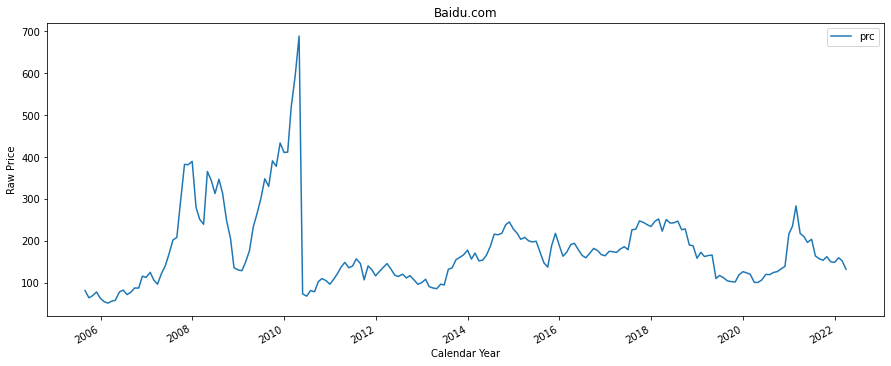

In [ ]:
msf.loc[90857].plot.line('date', 'prc', title='Baidu.com', ylabel='Raw Price', xlabel='Calendar Year', figsize=(15,6))

In [ ]:
msf.loc[90857][(msf.loc[90857]['date']>datetime(2010,1,1)) & (msf.loc[90857]['date']<=datetime(2010,10,1))][['date', 'comnam', 'prc', 'shrout', 'cfacpr', 'shrcd', 'exchcd']]

,date,comnam,prc,shrout,cfacpr,shrcd,exchcd
permno,,,,,,,
90857.0,2010-01-29,BAIDU INC,411.709991,26316.0,10.0,31.0,3.0
90857.0,2010-02-26,BAIDU INC,518.679993,26316.0,10.0,31.0,3.0
90857.0,2010-03-31,BAIDU INC,597.000000,26468.0,10.0,31.0,3.0
90857.0,2010-04-30,BAIDU INC,688.960022,26468.0,10.0,31.0,3.0
90857.0,2010-05-28,BAIDU INC,73.209999,264680.0,1.0,31.0,3.0
90857.0,2010-06-30,BAIDU INC,68.080002,267081.0,1.0,31.0,3.0
90857.0,2010-07-30,BAIDU INC,81.410004,267081.0,1.0,31.0,3.0
90857.0,2010-08-31,BAIDU INC,78.430000,267081.0,1.0,31.0,3.0
90857.0,2010-09-30,BAIDU INC,102.620003,267081.0,1.0,31.0,3.0


In [ ]:
msf['prc_adj']=msf['prc']/msf['cfacpr']

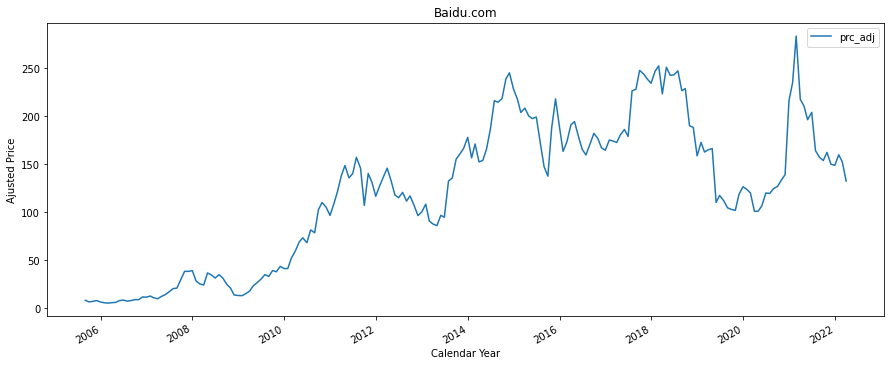

In [ ]:
msf.loc[90857].plot('date', 'prc_adj', title='Baidu.com', ylabel='Ajusted Price', xlabel='Calendar Year', figsize=(15,6))

> We focus on the stocks assigned a share code of 10 or 11 (Exclude ADRs, ETFs, etc.) and primarily listed in NYSE, AMEX, and Nasdaq. Also we start our data from 1962, when CRSP integrated AMEX.

In [ ]:
msf=msf[(msf['exchcd'].isin([1,2,3])) & msf['shrcd'].isin([10,11]) & (msf['date']>=datetime(1961,12,1))]

> We need to take a few steps to get Market Cap (market value) on firm level to match the Book Value of Equity from Compustat. Note one way to determine primary shares is to use the shares with larger Market Cap, though this approach many not be always right. Stock with ticker GOOG is, for example, Class-C shares (shares without voting rights)

![FFM Google](http://drive.google.com/uc?export=view&id=127MaQdyFsQdzEYTz95kRc5e5V66-z6su)

In [ ]:
msf['meq']=msf['prc'].abs()*msf['shrout'] # Do not forget to apply absolute operation on CRSP Stock Price

> ##### SQL solution to calculate market cap on firm level
`msf.to_sql('msf', local_sql)`  
`sqlcode="select distinct *, sum(meq) as meq_sum from msf group by permco, date "`  
`msf=pd.read_sql_query(sqlcode, local_sql)`

In [ ]:
msf=msf.join(msf.groupby(['permco', 'date'])['meq'].sum(), on=['permco', 'date'], rsuffix='_sum')

In [ ]:
msf=msf.rename({'meq_sum': 'me'}, axis=1) 

> Simple Rebalance (Academic Paper Rebalance)
> - The code below is conceptually the most straightforward solution to construct a value-weighted portfolio
> - All dividends are assumed to be reinvested proportionally based on the market value of stocks at the previous month end. 

In [ ]:
msf['thisMonthEnd']=msf['date']+ MonthEnd(0) # Push the last trading day of month to the last calendar month end
msf['nextMonthEnd']=msf['thisMonthEnd'] + MonthEnd(1) # Generate a new column containing next calendar month end

In [ ]:
msf=pd.merge(msf, msf[['nextMonthEnd','meq']], left_on=['permno','thisMonthEnd'], right_on=["permno", "nextMonthEnd"], how='left', suffixes=("","_lag"))

In [ ]:
msf['date']=msf['thisMonthEnd']
msf=msf.rename({'meq_lag': 'weight_port'}, axis=1) 
msf=msf[['date', 'ret', 'retadj', 'shrcd', 'exchcd', 'me', 'weight_port', 'nextMonthEnd']]

In [ ]:
msf.head()

,date,ret,retadj,shrcd,exchcd,me,weight_port,nextMonthEnd
permno,,,,,,,,
12160.0,1977-01-31,NaN,0.000000,10.0,3.0,6412.5000,NaN,1977-02-28
12160.0,1977-02-28,0.083333,0.083333,10.0,3.0,6946.8750,6412.5000,1977-03-31
12160.0,1977-03-31,-0.128205,-0.128205,10.0,3.0,6056.2500,6946.8750,1977-04-30
12160.0,1977-04-30,0.073529,0.073529,10.0,3.0,6501.5625,6056.2500,1977-05-31
12160.0,1977-05-31,0.054795,0.054795,10.0,3.0,6857.8125,6501.5625,1977-06-30


> Portfolio Reconstruction Alignment
> - A firm must have stocks prices for Dec at year t-1, and Jun at year t
![FFM Formula](http://drive.google.com/uc?export=view&id=125wcrwP961BBjGilXroPTiK5SkKkxm77)

In [ ]:
msf_dec=msf[msf["date"].dt.month==12]
msf_jun=msf[msf["date"].dt.month==6].copy()

In [ ]:
msf_jun['lastDec']=msf_jun['date']+MonthEnd(-6) # Create a New Column to push this Jun end to Previous Dec End

In [ ]:
msf_jun=pd.merge(msf_jun, msf_dec[["date", 'me']], left_on=['permno','lastDec'], right_on=["permno", "date"], suffixes=("","_dec"))

In [ ]:
msf_jun.head(3)

,date,ret,retadj,shrcd,exchcd,me,weight_port,nextMonthEnd,lastDec,date_dec,me_dec
permno,,,,,,,,,,,
12160.0,1978-06-30,0.044444,0.044444,10.0,3.0,8371.875,8015.625,1978-07-31,1977-12-31,1977-12-31,6946.8750
12160.0,1979-06-30,0.032258,0.032258,10.0,3.0,11400.000,11043.750,1979-07-31,1978-12-31,1978-12-31,8817.1875
12160.0,1980-06-30,0.022727,0.022727,10.0,3.0,15682.500,15334.000,1980-07-31,1979-12-31,1979-12-31,17837.2500


In [ ]:
msf_jun=msf_jun.rename({'me': 'jun_me', 'me_dec': 'dec_me'}, axis=1) 

In [ ]:
msf_jun=msf_jun[["date", "exchcd", "shrcd", "jun_me", "dec_me"]]

In [ ]:
msf_jun.head(3)

,date,exchcd,shrcd,jun_me,dec_me
permno,,,,,
12160.0,1978-06-30,3.0,10.0,8371.875,6946.8750
12160.0,1979-06-30,3.0,10.0,11400.000,8817.1875
12160.0,1980-06-30,3.0,10.0,15682.500,17837.2500


> CRSP/COMPUSTAT Merged
> - *LPERMCO*: CRSP PERMCO link during link period. It is set to null if there is no CRSP link during the range.
> - *LPERMNO*: CRSP PERMNO link during link period. It is set to null if there is no CRSP link during the range.
> - *LINKDT*: The first effective date of the link
> - *LINKENDDT*: The last date when the link is valid. For current valid link, LINKENDDT is set a NULL value. 
> - *LinkType*: A code describing the connection between the CRSP and Compustat data.
>   - *LU*:Link research complete. Standard connection between databases.
>   - *LC*:Un-researched link to issue by CUSIP.
>   - *LS*: Link valid for this security only. Other CRSP PERMNOs with the same permco will link to other GVKEYs
> - *LinkPrim*: Primary issue indicator for the link
>   - *P*: Primary, identified by Compustat in monthly security data.
>   - *C*: Primary, assigned by CRSP to resolve ranges of overlapping or missing primary markers from Compustat in order to produce one primary security throughout the company history.
>   - *J*:Joiner secondary issue of a company, identified by Compustat in monthly security data.


In [ ]:
ccmxpf_lnkhist = wrds_sql.raw_sql("""
          select distinct GVKEY,	LINKPRIM,	LINKTYPE,	LPERMNO,	LPERMCO,	LINKDT,	LINKENDDT
          from crsp.ccmxpf_lnkhist
        """)

In [ ]:
ccmxpf_lnkhist.head()

,gvkey,linkprim,linktype,lpermno,lpermco,linkdt,linkenddt
0,037110,P,LC,19994.0,57465.0,2020-10-09,None
1,003724,P,LU,40897.0,24494.0,1964-07-22,1990-01-09
2,036349,P,LC,19631.0,57238.0,2020-08-28,None
3,040112,P,NR,NaN,NaN,2021-11-30,None
4,061753,P,NU,NaN,NaN,2005-07-09,None


In [ ]:
# Keep Primary Shares and Checked Links
ccmxpf_lnkhist=ccmxpf_lnkhist[(ccmxpf_lnkhist['linktype'].isin(['LC', 'LU'])) & (ccmxpf_lnkhist['linkprim'].isin(['P','C']))]

In [ ]:
ccmxpf_lnkhist.tail(3)

,gvkey,linkprim,linktype,lpermno,lpermco,linkdt,linkenddt
110749,163036,P,LC,90720.0,46846.0,2005-06-22,None
110757,013288,C,LC,87816.0,18443.0,2000-03-21,2015-11-04
110758,004208,P,LC,52150.0,25230.0,1971-04-05,1976-12-31


In [ ]:
comp.to_sql('comp', local_sql, index=True) 
ccmxpf_lnkhist.to_sql('ccmxpf_lnkhist', local_sql)  

sqlcode="""
    select distinct a.*, b.lpermno as permno, b.linkprim
    from comp as a, ccmxpf_lnkhist as b
    where a.gvkey=b.gvkey and datadate>=linkdt and datadate<=coalesce(linkenddt, date("now"))
    group by b.lpermno, fyear
    having datadate=max(datadate) 
"""
ccm=pd.read_sql_query(sqlcode, local_sql)

In [ ]:
ccm.head(3)

,gvkey,fyear,datadate,be,age,permno,linkprim
0,013007,1986.0,1986-10-31 00:00:00,0.418,2.0,10000.0,P
1,012994,1986.0,1986-06-30 00:00:00,7.037,0.0,10001.0,P
2,012994,1987.0,1987-06-30 00:00:00,7.038,1.0,10001.0,P


In [ ]:
ccm.to_sql('ccm', local_sql, index=True) 
msf_jun.to_sql('msf_jun', local_sql, index=True)
sqlcode="""
    select a.*, b.BE, (1000*b.BE)/a.DEC_ME as beme, b.age, b.datadate
    from msf_jun as a, ccm as b
    where a.permno=b.permno and age > 2  and be > 0 and 
    datadate<=date and datadate>=date(date, "start of month", "-11 month") 
"""
ccm_jun=pd.read_sql_query(sqlcode, local_sql)

> Empirical Notes - Potential duplications: 
> - There are small numbers of cases that different GVKEYS are merged to the same PERMNO-Date combination
>   - Compustat and CRSP disagree regarding certain subsidiaries whose stocks are independently traded on the market.

In [ ]:
ccm_jun.head(3)

,permno,date,exchcd,shrcd,jun_me,dec_me,be,beme,age,datadate
0,10001.0,1989-06-30 00:00:00,3.0,11.0,7007.00,6362.25,8.466,1.330661,3.0,1989-06-30 00:00:00
1,10001.0,1990-06-30 00:00:00,3.0,11.0,10052.25,10347.75,9.438,0.912082,4.0,1990-06-30 00:00:00
2,10001.0,1991-06-30 00:00:00,3.0,11.0,11266.50,10013.00,10.411,1.039748,5.0,1991-06-30 00:00:00


> In the original Fama & French (1993), size and B/M break breakpoints are created by NYSE stocks only to ensure consistency introduced by the small stocks listed in the later joined NASDAQ (1973).
> - This treatment becomes a standard way to handle breaking points among Asset Pricing literature, even in the ones using data after CRSP NASDAQ data integration.  

In [ ]:
nyse_breaks=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0)] # NYSE Stocks with positive Book Value of Equity;

> Fama & French (1993) break NYSE stocks in two dimensions in each June:
> - Big and Small by median 
> - High and Low by 30- and 70- percentiles 

![FFM Formula](http://drive.google.com/uc?export=view&id=122xgaGmiDATj2gOl3X7SeaMti8fZ6gWC)

In [ ]:
nyse_breaks=nyse_breaks.groupby(['date'])[['jun_me', 'beme']].quantile([.3, .5, .7], interpolation='nearest').unstack().reset_index()

In [ ]:
nyse_breaks.tail(3)

date        jun_me                                  beme  \
                                  0.3           0.5           0.7       0.3   
57  2019-06-30 00:00:00  1.323978e+06  3.181894e+06  8.294303e+06  0.357084   
58  2020-06-30 00:00:00  1.044467e+06  2.720821e+06  7.109923e+06  0.306639   
59  2021-06-30 00:00:00  2.083823e+06  4.528185e+06  1.164222e+07  0.264976   

                        
         0.5       0.7  
57  0.583190  0.850418  
58  0.514130  0.754795  
59  0.470324  0.773158

In [ ]:
# Some manipulation for panda's hierarchical column names
nyse_breaks.columns=[col[0]+str(col[1]).replace('0.','_q') for col in nyse_breaks.columns.values] 

In [ ]:
nyse_breaks.head(2)

,date,jun_me_q3,jun_me_q5,jun_me_q7,beme_q3,beme_q5,beme_q7
0,1962-06-30 00:00:00,126653.25,261765.0,410720.75,0.397120,0.451566,0.508569
1,1963-06-30 00:00:00,103194.00,221805.0,434875.00,0.446089,0.525711,0.675712


> Group all remaining stocks at each Jun into one of 6 categories

In [ ]:
nyse_breaks.to_sql('nyse_breaks', local_sql, index=False)
ccm_jun.to_sql('ccm_jun', local_sql, index=False) 

sqlcode=""" 
    select a.permno, a.date, a.exchcd, a.shrcd, 
    case when JUN_ME <= jun_me_q5 then 'S' else 'B' end as sizeport,
    case when beme <= beme_q3 then 'L' when beme > beme_q7 then 'H'
    else 'M' end as btmport
    from ccm_jun as a inner join nyse_breaks as b
    on a.date=b.date and shrcd in (10,11) 
"""

ccm_nyse_port=pd.read_sql_query(sqlcode, local_sql)

In [ ]:
ccm_nyse_port.head(2)

,permno,date,exchcd,shrcd,sizeport,btmport
0,10001.0,1989-06-30 00:00:00,3.0,11.0,S,H
1,10001.0,1990-06-30 00:00:00,3.0,11.0,S,M


> Fama French (1993) to keep the stock in the same portfolio and carry forward for 12 months
> - For simplicity, I use previous market cap to construct weight factors:
![FFM Weight](http://drive.google.com/uc?export=view&id=11jdZjIaKCvoC_tcFvWudlHSpF-jCnomg)

In [ ]:
ccm_nyse_port.to_sql('ccm_nyse_port', local_sql, index=False)
msf[msf['weight_port']>0].to_sql('msf', local_sql, index=True) 

sqlcode=""" 
    select a.*, b.sizeport, b.btmport, b.date as portdate, date(b.date, "start of month", "+13 month")  as next_july
    from msf as a, ccm_nyse_port as b
    where a.permno=b.permno and a.date>b.date and
    a.date<date(b.date, "start of month", "+13 month") 
    order by a.date, sizeport, btmport
"""

port_ccm=pd.read_sql_query(sqlcode, local_sql)

In [ ]:
port_ccm.to_sql('port_ccm', local_sql, index=False) 

sqlcode=""" 
    select distinct date, sizeport, btmport, count(distinct permno) as n_firms,
    sum(weight_port*retadj)/sum(weight_port) as vwret
    from port_ccm
    group by date, sizeport, btmport
"""

port_ccm_vwret=pd.read_sql_query(sqlcode, local_sql)

In [ ]:
port_ccm_vwret['port_type']=port_ccm_vwret['sizeport']+port_ccm_vwret['btmport']
port_ccm_vwret['date']=pd.to_datetime(port_ccm_vwret['date'])
port_ccm_vwret.head(3)

,date,sizeport,btmport,n_firms,vwret,port_type
0,1962-07-31,B,H,10,0.059781,BH
1,1962-07-31,B,L,13,0.095592,BL
2,1962-07-31,B,M,17,0.071807,BM


In [ ]:
# local_sql.close()
# wrds_sql.close()
# del [comp, ccm, msf, msf_jun, ccmxpf_lnkhist, nyse_breaks, ccm_nyse_port, port_ccm, local_sql, wrds_sql]

In [ ]:
ff_vwret=port_ccm_vwret.pivot(index='date', columns="port_type", values='vwret')

In [ ]:
ff_vwret.head(3)

port_type,BH,BL,BM,SH,SL,SM
date,,,,,,
1962-07-31,0.059781,0.095592,0.071807,0.030883,0.069460,0.075573
1962-08-31,0.040105,0.030217,0.027753,0.023607,0.033278,0.027525
1962-09-30,-0.028539,-0.022686,-0.038757,-0.025749,-0.009178,-0.001652


> I then follow Fama and French (1993) to construct HML and SMB factors: 
![FFM Weight](http://drive.google.com/uc?export=view&id=12Ea_jNzq5dzxlCjJxmiw8wNRMhPPa_Nv)


In [ ]:
ff_vwret['High']=(ff_vwret['BH']+ff_vwret['SH'])/2
ff_vwret['Low']=(ff_vwret['BL']+ff_vwret['SL'])/2
ff_vwret['HML']=ff_vwret['High'] - ff_vwret['Low']

ff_vwret['Small']=(ff_vwret['SL']+ff_vwret['SM']+ff_vwret['SH'])/3
ff_vwret['Big']=(ff_vwret['BL']+ff_vwret['BM']+ff_vwret['BH'])/3
ff_vwret['SMB']=ff_vwret['Small']-ff_vwret['Big']

In [ ]:
ff_vwret.tail(2)

port_type,BH,BL,BM,SH,SL,SM,High,Low,HML,Small,Big,SMB
date,,,,,,,,,,,,
2022-02-28,0.009284,-0.038501,-0.00284,0.026749,-0.004099,0.012033,0.018016,-0.021300,0.039316,0.011561,-0.010686,0.022247
2022-03-31,0.024046,0.042120,0.01547,0.013909,0.020105,0.002066,0.018977,0.031112,-0.012135,0.012027,0.027212,-0.015185


> Compare with Data from Prof French's data library: 

In [ ]:
ff = wrds_sql.raw_sql("""
          select distinct mktrf, smb, hml, rf, umd, dateff
          from ff.factors_monthly
        """)
ff['dateff']=pd.to_datetime(ff['dateff'])

In [ ]:
ff.head(2)

,mktrf,smb,hml,rf,umd,dateff
0,-0.0114,-0.0265,0.0047,0.0034,0.0182,1972-09-29
1,0.0418,0.0859,-0.0552,0.0054,-0.0880,1970-09-30


In [ ]:
ff_vwret=pd.merge(ff_vwret, ff[['hml', 'smb', 'dateff']], left_on='date', right_on='dateff')
ff_factor=ff_vwret[['High', 'Low', 'Big', 'Small', 'HML', 'SMB', 'hml', 'smb', 'dateff']]
ff_factor=ff_factor.set_index('dateff')
ff_factor=ff_factor.rename({'hml': 'FF_HML', 'smb': 'FF_SMB'}, axis=1) 
ff_factor.tail(2)

,High,Low,Big,Small,HML,SMB,FF_HML,FF_SMB
dateff,,,,,,,,
2022-02-28,0.018016,-0.021300,-0.010686,0.011561,0.039316,0.022247,0.0309,0.0218
2022-03-31,0.018977,0.031112,0.027212,0.012027,-0.012135,-0.015185,-0.0182,-0.0161


#### Correlation Analysis:

In [ ]:
print("{:.5f}, {:.5f}".format(ff_factor['HML'].corr(ff_factor['FF_HML']), ff_factor['SMB'].corr(ff_factor['FF_SMB'])))

0.97098, 0.98667


#### Graphic Comparison:

In [ ]:
ff_factor['Cumulative_HML']=(1 + ff_factor['HML']).cumprod() - 1  
ff_factor['Cumulative_FF_HML']=(1 + ff_factor['FF_HML']).cumprod() - 1  
ff_factor['Cumulative_SMB']=(1 + ff_factor['SMB']).cumprod() - 1  
ff_factor['Cumulative_FF_SMB']=(1 + ff_factor['FF_SMB']).cumprod() - 1  

ff_factor['Cumulative_Small']=(1 + ff_factor['Small']).cumprod() - 1  
ff_factor['Cumulative_Big']=(1 + ff_factor['Big']).cumprod() - 1  
ff_factor['Cumulative_High']=(1 + ff_factor['High']).cumprod() - 1  
ff_factor['Cumulative_Low']=(1 + ff_factor['Low']).cumprod() - 1  

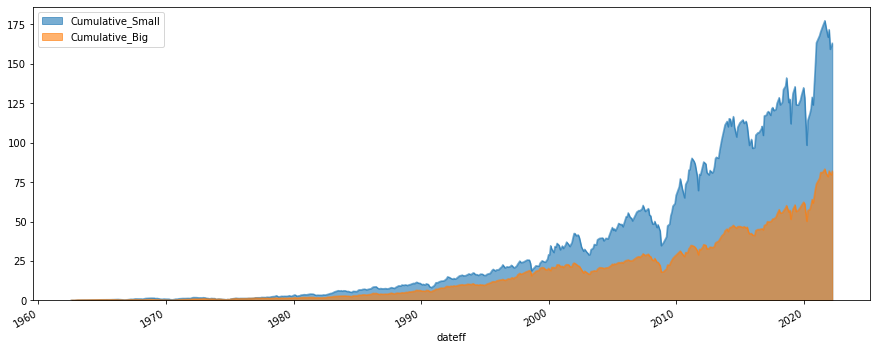

In [ ]:
ff_factor[['Cumulative_Small','Cumulative_Big']].plot.area(figsize=(15,6), stacked=False, alpha=.6)

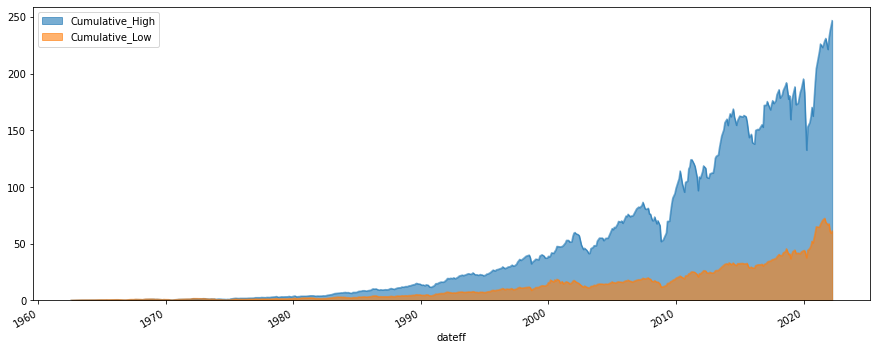

In [ ]:
ff_factor[['Cumulative_High','Cumulative_Low']].plot.area(figsize=(15,6), stacked=False, alpha=.6)

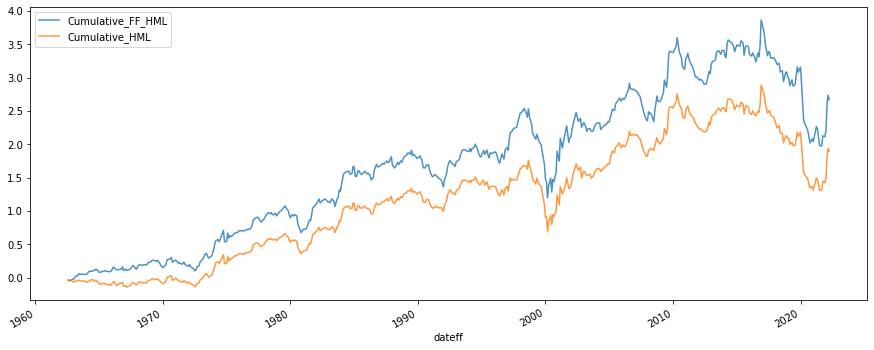

In [ ]:
ff_factor[['Cumulative_FF_HML','Cumulative_HML']].plot.line(figsize=(15,6), alpha=.8)

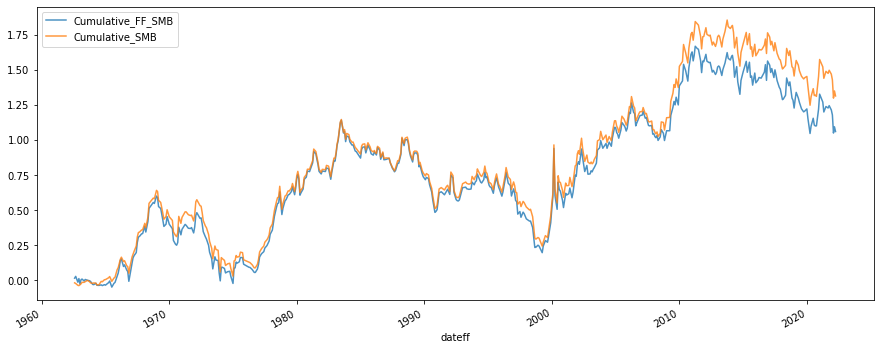

In [ ]:
ff_factor[['Cumulative_FF_SMB','Cumulative_SMB']].plot.line(figsize=(15,6), alpha=.8) 

> Discrepancy or Limitations
> - Adding delist return would not be sufficient to eliminate the look-forward bias in the monthly rebalance.
> - Fama & French replaces the missing Compustat accounting items by Moody, so that their portfolios covering more firms.
> ![FFM Universe](http://drive.google.com/uc?export=view&id=11uKYG-G_QxaZevtyAUtiLFtvfdGHkNWN)

